In [8]:
# Imporitng all the necessary libraries
import os
import cv2
import random

import numpy as np
import pandas as pd

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from tensorflow.keras import layers,applications
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

In [9]:
# specifying the image size we want to input in model
picture_size=48

# Path where the data is stored
folder_path = ('../input/fer2013')

In [10]:
# lsit of all classes
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

angry
disgust
fear
happy
neutral
sad
surprise


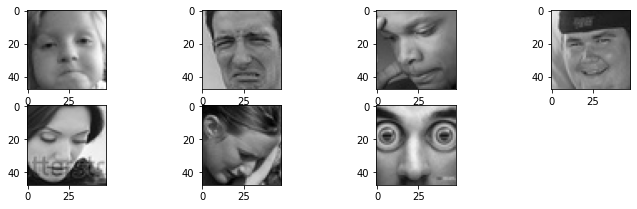

(48, 48, 3)


In [11]:
# viewing some of the images from each category
plt.figure(figsize= (12,12))
i=1
for category in classes:
    for j in range(1,5):
        plt.subplot(7,4,i)
        img = load_img("../input/fer2013/train/"+category+"/"+
                  os.listdir("../input/fer2013/train/" + category)[j], target_size=(picture_size, picture_size))
    plt.imshow(img)
    i+=1
    print(category) 
plt.show()
x=img_to_array(img)
print(x.shape)

In [12]:
# Find the count of images in each category
category=[]
examples=[]
for i in classes:
    dir='../input/fer2013/train/'+i
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    category.append(i)
    examples.append(len(onlyfiles))

Exploratory Data Analysis

In [13]:
# Create a dataframe for the count of images
example_count_df=pd.DataFrame(category,columns=['Category'],index=[1,2,3,4,5,6,7])
example_count_df['No. of images']=examples
example_count_df

,Category,No. of images
1,angry,3995
2,disgust,436
3,fear,4097
4,happy,7215
5,neutral,4965
6,sad,4830
7,surprise,3171


Text(0.5, 1.0, 'Count of images in each category')

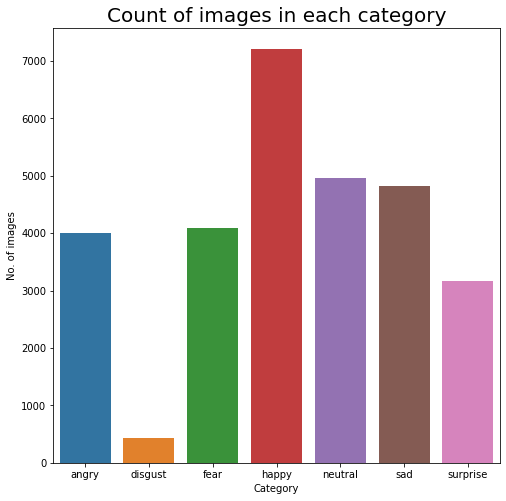

In [14]:
# visualizing distribution
plt.figure(figsize=(8,8))
sns.barplot(x=example_count_df['Category'],y=example_count_df['No. of images'])
plt.title('Count of images in each category',fontsize=20)

In [15]:
# defining the train and test set 
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory("../input/fer2013/train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory("../input/fer2013/test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
# defining a CNN model
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-07-12 07:41:25.632551: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [17]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# defining no. of epoch
epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [18]:
# Fitting and training the model
history = model.fit(train_set,
                        epochs=epochs,
                        validation_data = test_set,
                        callbacks=callbacks_list
                        )

2022-07-12 07:43:36.102989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/48
225/225 [==============================] - 480s 2s/step - loss: 1.8450 - accuracy: 0.2783 - val_loss: 1.9718 - val_accuracy: 0.2471

Epoch 00001: val_accuracy improved from -inf to 0.24714, saving model to model.h5
Epoch 2/48
225/225 [==============================] - 463s 2s/step - loss: 1.5554 - accuracy: 0.3990 - val_loss: 1.8285 - val_accuracy: 0.2717

Epoch 00002: val_accuracy improved from 0.24714 to 0.27166, saving model to model.h5
Epoch 3/48
225/225 [==============================] - 463s 2s/step - loss: 1.3948 - accuracy: 0.4638 - val_loss: 1.5274 - val_accuracy: 0.4113

Epoch 00003: val_accuracy improved from 0.27166 to 0.41126, saving model to model.h5
Epoch 4/48
225/225 [==============================] - 464s 2s/step - loss: 1.3011 - accuracy: 0.4987 - val_loss: 1.3070 - val_accuracy: 0.4923

Epoch 00004: val_accuracy improved from 0.41126 to 0.49234, saving model to model.h5
Epoch 5/48
225/225 [==============================] - 464s 2s/step - loss: 1.2441 - acc

In [1]:
# loading the saved model
trained_model=load_model('model.h5')

NameError: name 'load_model' is not defined

In [ ]:
# evaluating the train set
trained_model.evaluate(train_set)

167/225 [=====================>........] - ETA: 34s - loss: 0.5336 - accuracy: 0.8086

In [ ]:
# evaluating the test set
trained_model.evaluate(test_set)

In [ ]:
# plotting the Loss for training and validation set
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')